# Changes

This notebook makes the NN take in an activation function as input, to compare different activation functions

In [81]:
import pandas as pd

Read the data and find the different vectors

In [82]:
# data_path = ".\original_dataset\dataset_bd_wnames.csv" #Windows
data_path = "original_dataset/dataset_bd_wnames.csv"  #MACos
df = pd.read_csv(data_path)
df.head()
df.iloc[1,:]

ID           HD 203977
sp_type             A0
RAdeg        321.20044
DEdeg        25.880459
PS1gmag            NaN
e_PS1gmag          NaN
PS1rmag         7.6116
e_PS1rmag        0.001
PS1imag            NaN
e_PS1imag          NaN
PS1zmag         7.5167
e_PS1zmag        0.001
PS1ymag        13.5874
e_PS1ymag       0.0028
W1mag             6.88
W2mag            6.919
W3mag            6.946
W4mag            6.484
e_W1mag          0.059
e_W2mag           0.02
e_W3mag          0.016
e_W4mag          0.059
Jmag             6.896
Hmag             6.921
Kmag             6.932
e_Jmag           0.026
e_Hmag           0.024
e_Kmag           0.016
label                0
Name: 1, dtype: object

Fill missing values with the mean of the vector

In [83]:
for column in df.columns:
    if column in ["ID", "sp_type"]: #Skipping these
        continue
  
    df[column] = df[column].fillna(df[column].mean()) #Imputing NA values with mean

df.head()

,ID,sp_type,RAdeg,DEdeg,PS1gmag,e_PS1gmag,PS1rmag,e_PS1rmag,PS1imag,e_PS1imag,...,e_W2mag,e_W3mag,e_W4mag,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,label
0,* 11 Peg,A0V,326.80817,2.686124,5.55600,0.02303,5.760000,0.027126,5.947000,0.022877,...,0.050,0.015,0.044000,5.562,5.539,5.479,0.017,0.026,0.020,0
1,HD 203977,A0,321.20044,25.880459,15.12594,0.02303,7.611600,0.001000,14.918063,0.022877,...,0.020,0.016,0.059000,6.896,6.921,6.932,0.026,0.024,0.016,0
2,HD 83162,A0III/IV,144.03845,-12.459262,10.51200,0.02303,10.692000,0.027126,10.866000,0.022877,...,0.020,0.074,0.099197,10.408,10.400,10.378,0.026,0.021,0.023,0
3,* 10 Boo,A0Vs,209.66217,21.696203,15.12594,0.02303,14.982256,0.027126,6.860300,0.104200,...,0.046,0.015,0.037000,5.671,5.717,5.704,0.023,0.063,0.020,0
4,HD 27616,A0V,65.16255,-20.639620,15.12594,0.02303,14.982256,0.027126,6.320600,0.000000,...,0.072,0.015,0.036000,5.430,5.402,5.333,0.054,0.036,0.017,0


Encode the vector "sp_type" as it is categorical

In [84]:
X = df.drop('ID', axis=1)
unique_values =len(X["sp_type"].unique()) # 504
X['sp_type'], _ = pd.factorize(X['sp_type'])

Split the dataframe/array into data and ground truth

In [85]:
y = X["label"]
X = X.drop(columns=["label"])


In [86]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale the data with respect to the training data X_train

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

PCA to find the five vectors with the most variance, five is choosen arbitrarly

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [89]:
import numpy as np
y_train, y_test = np.array(y_train), np.array(y_test)

Neural Net for binary classification 5x64x32x1

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Convert numpy arrays or pandas DataFrames to PyTorch tensors if needed
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Defining a simple neural network class for binary classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, activation):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.activation = activation       # Arbitrary activation function
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer with single neuron (binary classification)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid activation for binary classification of final output
        return x


In [91]:
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Hardtanh()]
losses = [] #Might turn into dict to make it more readable
for activation in activation_functions:
    print(f"Training with activation function: {activation}")
    # Initialize the neural network
    input_size = X_train.shape[1]
    model = NeuralNet(input_size, activation)

    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare data for training using DataLoader
    batch_size = 64
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    num_epochs = 10
    temp_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze(dim=1)  # Remove extra dimension for binary classification
            loss = criterion(outputs, labels.float())  # Calculate loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        temp_loss.append(running_loss / len(train_loader))
    losses.append(temp_loss)

    # Example: Make predictions
    # Assuming X_test is your test data
    X_test = torch.tensor(X_test, dtype=torch.float32)
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        predictions = model(X_test)
        predictions = (predictions > 0.5).int()  # Convert probabilities to binary predictions (0 or 1)

    #Saving model for later use
    torch.save(model.state_dict(), './models/activation_test/'+type(activation).__name__+'_binary_classification_model.pth') #Windows




Training with activation function: ReLU()
Epoch 1, Loss: 0.23130279538077367
Epoch 2, Loss: 0.08561729776187682
Epoch 3, Loss: 0.07644116526968042
Epoch 4, Loss: 0.07425474856888324
Epoch 5, Loss: 0.07146950286458915
Epoch 6, Loss: 0.06989442683021788
Epoch 7, Loss: 0.06859297955303754
Epoch 8, Loss: 0.06687262951409523
Epoch 9, Loss: 0.06640442127598004
Epoch 10, Loss: 0.06436048457267839
Training with activation function: Sigmoid()
Epoch 1, Loss: 0.5383932708014905
Epoch 2, Loss: 0.31575313168512265
Epoch 3, Loss: 0.16566518568237062
Epoch 4, Loss: 0.13026241606599848
Epoch 5, Loss: 0.11882227779903883
Epoch 6, Loss: 0.11529325515451566
Epoch 7, Loss: 0.11199580363824334
Epoch 8, Loss: 0.10933301624068072
Epoch 9, Loss: 0.10729433966039771
Epoch 10, Loss: 0.10527702394715498


C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\1365282481.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


Training with activation function: Tanh()
Epoch 1, Loss: 0.2477248256475153
Epoch 2, Loss: 0.12266137183342181
Epoch 3, Loss: 0.11406810867639494
Epoch 4, Loss: 0.10842259587641333
Epoch 5, Loss: 0.10227349801907237
Epoch 6, Loss: 0.09879915250963728
Epoch 7, Loss: 0.09152691577836661
Epoch 8, Loss: 0.08663136973767213
Epoch 9, Loss: 0.08439941096945967
Epoch 10, Loss: 0.07957610333154738
Training with activation function: Hardtanh(min_val=-1.0, max_val=1.0)
Epoch 1, Loss: 0.21709173235674978
Epoch 2, Loss: 0.12101873734467467
Epoch 3, Loss: 0.11070107422034506
Epoch 4, Loss: 0.10077548827188955
Epoch 5, Loss: 0.09375581035101918
Epoch 6, Loss: 0.08701637686348297
Epoch 7, Loss: 0.08080929045526075
Epoch 8, Loss: 0.07697539175794997
Epoch 9, Loss: 0.07278257870758084
Epoch 10, Loss: 0.07043419501573688


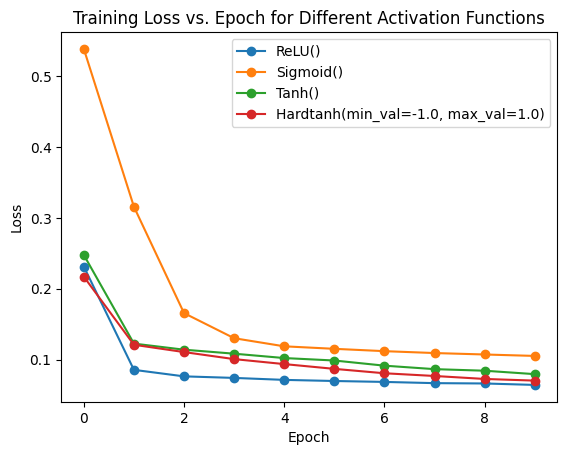

In [92]:
import matplotlib.pyplot as plt
for i, loss in enumerate(losses):
    plt.plot(loss, "-o", label=str(activation_functions[i]))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch for Different Activation Functions")
plt.show()

Testing with F1 score as brown dwarfs are rare which is also true in the data set

In [93]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix


all_metrics = {}
all_confusion_matrices = {}
for activation in activation_functions:
    print(f"Evaluating model with activation function: {activation}")
    # Load the trained model
    input_size = 5  # Assuming the input size based on X_train
    model = NeuralNet(input_size, activation)
    # model.load_state_dict(torch.load('./models/binary_classification_model.pth'))  # Load the trained model state  (Windows)
    model.load_state_dict(torch.load('models/activation_test/'+type(activation).__name__+'_binary_classification_model.pth'))  # Load the trained model state (MACos)


    # Assuming X_test and y_test are your test data
    X_test = X_test.float()
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Prepare test dataset and dataloader
    batch_size = 64
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    # Evaluate the model on the test set using F1 score
    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    print(test_loader)
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1}")

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print("Matthews Correlation Coefficient (MCC):", mcc)

    # Compute accuracy, precision and recall
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')  # Change average as needed
    recall = recall_score(y_true, y_pred, average='binary')  # Change average as needed

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:", conf_matrix)

    # Store the metrics in a dictionary for easy plotting
    metrics = {'F1 Score': f1, 'MCC': mcc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    
    all_metrics[type(activation).__name__] = metrics
    all_confusion_matrices[type(activation).__name__] = conf_matrix

Evaluating model with activation function: ReLU()
F1 Score: 0.9669291338582677
Matthews Correlation Coefficient (MCC): 0.9541275263869796
Accuracy: 0.9814814814814815
Precision: 0.959375
Recall: 0.9746031746031746
Confusion Matrix: [[806  13]
 [  8 307]]
Evaluating model with activation function: Sigmoid()
F1 Score: 0.9473684210526315
Matthews Correlation Coefficient (MCC): 0.9272796428027865
Accuracy: 0.9708994708994709
Precision: 0.9519230769230769
Recall: 0.9428571428571428
Confusion Matrix: [[804  15]
 [ 18 297]]
Evaluating model with activation function: Tanh()
F1 Score: 0.9589905362776026
Matthews Correlation Coefficient (MCC): 0.943115704766402
Accuracy: 0.9770723104056437
Precision: 0.9529780564263323
Recall: 0.9650793650793651
Confusion Matrix: [[804  15]
 [ 11 304]]
Evaluating model with activation function: Hardtanh(min_val=-1.0, max_val=1.0)
F1 Score: 0.9559748427672956
Matthews Correlation Coefficient (MCC): 0.9389007905899994
Accuracy: 0.9753086419753086
Precision: 0.9470

C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\2163641453.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)
C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\2163641453.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)
C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\2163641453.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


<Axes: xlabel='Metrics'>

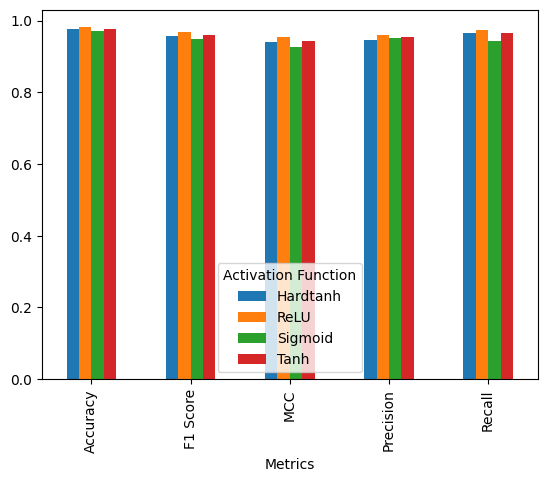

In [94]:
# Convert the all_metrics dictionary to a DataFrame
data = pd.DataFrame(all_metrics)

# Reset the index to make 'Metrics' a column
data = data.reset_index().rename(columns={'index': 'Metrics'})

# Melt the DataFrame to get it in long format
data = pd.melt(data, id_vars='Metrics', var_name='Activation Function', value_name='Value')

# Set the index and unstack the DataFrame
data = data.set_index(['Metrics', 'Activation Function']).Value
data.unstack().plot(kind='bar', stacked=False)

## Confusion matrix comparison

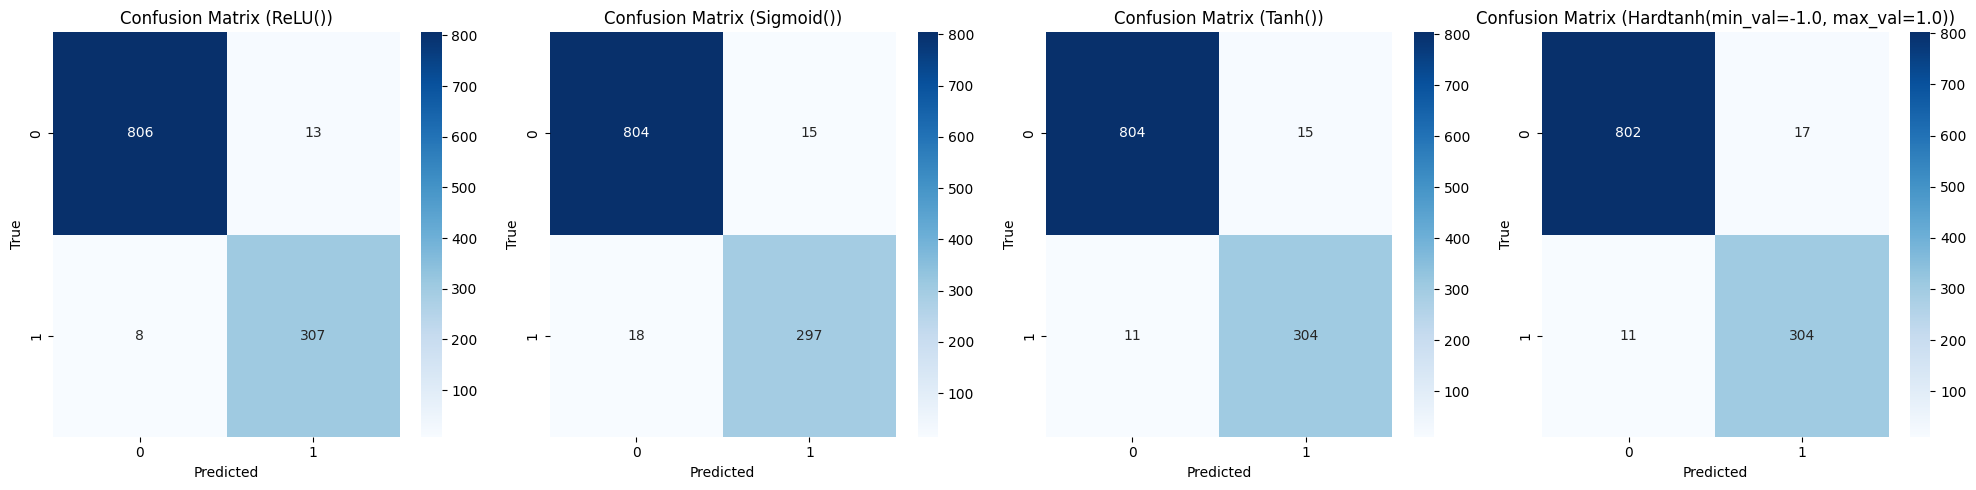

In [95]:
import seaborn as sns

fig, axes = plt.subplots(1, len(activation_functions), figsize=(20, 5))

for i, activation in enumerate(activation_functions):
    # Assume you have a function `get_conf_matrix` that returns the confusion matrix for a given activation function
    conf_matrix = all_confusion_matrices[type(activation).__name__]

    # Create a heatmap for the confusion matrix on the i-th subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])

    # Set the title, x-label, and y-label for the i-th subplot
    axes[i].set_title(f'Confusion Matrix ({activation})')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()